In [36]:
# Common imports
import numpy as np
import os


In [37]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [38]:
##########  Using gym
import gymnasium as gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
# Let's build the DQN. 
# Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after 
# it plays that action (but before it sees its outcome):

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("ALE/MarioBros-v5",render_mode="rgb_array")
input_shape =env.observation_space.shape
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Flatten(),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)  # NEW It is a clone of the online model
target.set_weights(model.get_weights())   # NEW
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 210, 160, 32)      128       
                                                                 
 dense_1 (Dense)             (None, 210, 160, 32)      1056      
                                                                 
 flatten (Flatten)           (None, 1075200)           0         
                                                                 
 dense_2 (Dense)             (None, 18)                19353618  
                                                                 
Total params: 19,354,802
Trainable params: 19,354,802
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that 
# the agent explores the environment, we choose a random action with probability epsilon.

def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        #print("Q_values", Q_values)
        return np.argmax(Q_values)

In [41]:
# We will also need a replay memory. It will contain the agent's experiences, 
# in the form of tuples: (obs, action, reward, next_obs, done). 
# We can use the deque class for that (but make sure to check out DeepMind's excellent Reverb library for 
# a much more robust implementation of experience replay):

from collections import deque

replay_memory = deque(maxlen=2000)

In [42]:
# And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: 
# [obs, actions, rewards, next_obs, dones].

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [43]:
# Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [44]:
# Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    #next_Q_values = model.predict(next_states)  # ORIGINAL DQN
    next_Q_values = target.predict(next_states)  # NEW  Using the target model instead the online model 
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)   # Use of the online model
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [45]:
#########  MODEL TRAINING 
#env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [46]:
for episode in range(600):
    obs = env.reset() 
    obs = obs[0]
    print("Se resetea")
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    #print(" Episodio vvvv", episode)
    if episode > 50:
        #print(" batch size vvvv", batch_size)      
        training_step(batch_size)
    if episode % 50 == 0:     ## Updating weights
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 195ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 91ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 60ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 60ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 60ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 64ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 73ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 63ms/step


KeyboardInterrupt: 

We run 600 episodes, each for a maximum of 200 steps. At each step, we first compute the epsilon value for the ε-greedy policy: it will go from 1 down to 0.01, linearly, in a bit under 500 episodes. 

Then we call the play_one_step() function, which will use the ε-greedy policy to pick an action, then execute it and record the experience in the replay buffer. 

If the episode is done, we exit the loop. Finally, if we are past the 50th episode, we call the training_step() function to train the model on one batch sampled from the replay buffer. The reason we play 50 episodes without training is to give the replay buffer some time to fill up (if we don’t wait enough, then there will not be enough diversity in the replay buffer). 

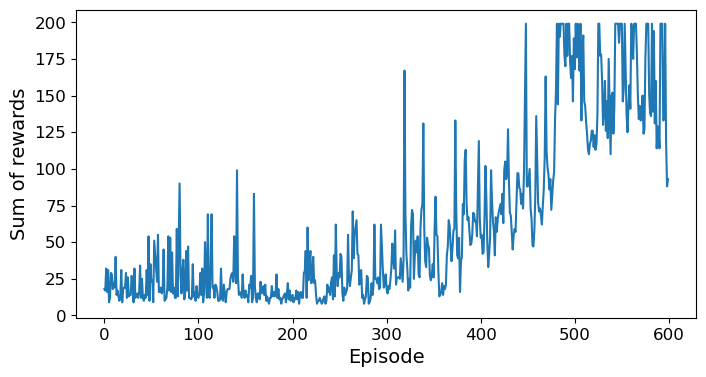

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
env = gym.make("CartPole-v1",render_mode="rgb_array")

state = env.reset()
state = state[0]

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state, epsilon)
    state, reward, done, tr,info = env.step(action)
    if done:
        break
    img = env.render()
    frames.append(img)
    
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Q_values [[8.598046 8.673566]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Q_values [[8.657488 8.609134]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Q_values [[8.608572 8.666587]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Q_values [[8.662588 8.595369]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Q_values [[8.619564 8.657238]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Q_values [[8.667155 8.578004]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Q_values [[8.630843 8.644942]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Q_values [[8.670822 8.556233]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Q_values [[8.642079 8.628917]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Q_values [[8.562628 8.660404]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Q_values [[8.637741 8.618446]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Q_values [[8.561287 8.653494]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Q_values [[8.634221 8.609225]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Q_values [[8.560693 8.647582]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/s

In [ ]:
env.close()